# **Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from ase import Atoms
from ase.visualize import view
from ase.io.trajectory import Trajectory

# ***Global Optima of Lennard-Jones Cluster***

## Constant values

In [2]:
epsilon = 1.0
sigma = 1.0
sigma_squared = sigma**2
rc = 2.5 * sigma
rc_squared = rc**2

rc_term = 4 * epsilon * ((rc/sigma)**(-12) - (rc/sigma)**(-6))

## Random Positions Initialization

In [3]:
def initialize_positions(N, L):
    return np.random.uniform(-L/2, L/2, (N,3))

## Potential Energy Calculation

In [21]:
def calculate_energy(positions, L, include_cohesive=True):
    N = len(positions)
    total_energy = 0.0
    alpha = 0.0001 * (N**(-2/3))

    for i in range(N):
        if include_cohesive:
            total_energy += alpha * (np.linalg.norm(positions[i], 2)**2)
        for j in range(i+1, N):   # Pairwise
            rij = positions[j] - positions[i]
            rij -= np.round(rij / L) * L   # Periodic boundary condition
            rij_squared = (rij**2).sum()   
            if rij_squared <= rc_squared:   # Ignore the energy at r_cut
                inv_rij_6 = (sigma_squared/rij_squared)**3
                total_energy += 4 * epsilon * inv_rij_6 * (inv_rij_6 - 1) - rc_term
    
    return total_energy

## Forces Calculation

In [22]:
def calculate_forces(positions, L):
    N = len(positions)
    alpha = 0.0001 * (N**(-2/3))
    forces = -2 * alpha * positions

    for i in range(N):
        for j in range(i+1, N):   # Pairwise
            rij_vec = positions[j] - positions[i]
            rij = rij_vec - np.round(rij_vec / L) * L   # Periodic boundary condition
            rij_squared = (rij**2).sum()   
            
            if rij_squared <= rc_squared:   # Ignore the forces at r_cut
                inv_rij_6 = (sigma_squared/rij_squared)**3
                f_ij = -24 * epsilon * inv_rij_6 * (2*inv_rij_6 - 1) * (1/rij_squared) * rij_vec
                forces[i] += f_ij
                forces[j] -= f_ij

    return forces

### *Alternative: Combined function to compute Potential Energy and Forces*

In [23]:
def calculate_energy_and_forces(positions, L, include_cohesive=True):
    N = len(positions)
    total_energy = 0
    alpha = 0.0001 * (N**(-2/3))

    forces = -2 * alpha * positions   # Cohesive forces
    for i in range(N):
        if include_cohesive:
            total_energy += alpha * (np.linalg.norm(positions[i], 2)**2)   # Cohesive energy
        for j in range(i+1, N):   # Pairwise
            rij = positions[j] - positions[i]
            rij -= np.round(rij / L) * L   # Periodic boundary condition
            rij_squared = (rij**2).sum()   
            
            if rij_squared <= rc_squared:   # Ignore the energy and forces at r_cut
                inv_rij_12 = (sigma/rij_squared)**6
                inv_rij_6 = (sigma/rij_squared)**3

                total_energy += 4 * epsilon * (inv_rij_12 - inv_rij_6 - inv_rc_12 + inv_rc_6)

                f_ij = -24 * epsilon / rij_squared * (2*inv_rij_12 - inv_rij_6) * rij
                forces[i] += f_ij
                forces[j] -= f_ij

    
    return total_energy, forces

## Line Search Method

In [24]:
def perform_line_search(positions, d, L, delta=0.001, LStol=1e-8, LSStep=0, MaxLSSteps=100000, include_cohesive=True):
    N = len(positions)
    for i in range(N):
        d[i] = d[i] / math.sqrt((d[i]**2).sum())
    r0 = np.copy(positions)
    r1 = r0 + delta * d
    r2 = r1 + delta * d

    U0 = calculate_energy(r0, L, include_cohesive)
    U1 = calculate_energy(r1, L, include_cohesive)
    U2 = calculate_energy(r2, L, include_cohesive)
    LSStep += 1
    while LSStep < MaxLSSteps:
        # if U2 > U1 and U0 > U1:
        #     r = (3-math.sqrt(5)) / 2
        #     h = (r2 - r0) * r
        #     rm1 = r0 + h
        #     Um1 = calculate_energy(rm1, L)
        #     rm2 = r2 - h
        #     Um2 = calculate_energy(rm2, L)

        #     while abs(U2-U0) >= LStol*abs(U0):
        #         if Um1 < Um2:
        #             r2, U2 = rm2, Um2
        #             rm2, Um2 = rm1, Um1

        #             rm1 = r0 + (r2 - r0)*r
        #             Um1 = calculate_energy(rm1, L)
        #         else:
        #             r0, U0 = rm1, Um1
        #             rm1, Um1 = rm2, Um2

        #             rm2 = r2 - (r2 - r0)*r
        #             Um2 = calculate_energy(rm2, L)

        #     return rm1, Um1


        if U2 > U1 and U0 > U1:   # Found a valid bracket
            # When found a suitable bracket, refine using bisection method

            while abs(U2-U0) >= LStol * abs(U0):
                rm1 = (r0 + r1) / 2
                rm2 = (r1 + r2) / 2
                Um1 = calculate_energy(rm1, L)
                Um2 = calculate_energy(rm2, L)
                if Um1 < Um2:
                    r2, U2 = r1, U1
                    r1, U1 = rm1, Um1
                elif Um1 > Um2:
                    r0, U0 = r1, U1
                    r1, U1 = rm2, Um2
                elif Um1 == Um2:
                    r0, U0 = rm1, Um1
                    r2, U2 = rm2, Um2
            
            return r1, U1
        
        if U0 < U1 and abs(U1-U0) >= LStol*abs(U0):
            delta *= 0.5
            return perform_line_search(r0, d, L, delta=delta, LSStep=LSStep, include_cohesive=include_cohesive)
        
        elif U0 < U1:
            return r0, U0
        
        # Shift the bracket
        r0, U0 = r1, U1
        r1, U1 = r2, U2
        r2 += delta * d
        U2 = calculate_energy(r2, L)
        LSStep += 1
    
    return r1, U1

## Conjugate Gradient Method

In [25]:
def perform_conjugate_gradient_minimization(positions, L, ECtol = 1e-10, MaxCGSteps = 100000):
    N = len(positions)
    
    trajectory = [positions]   # Store the positions at each iteration for visualizing the trajectory

    f0 = calculate_forces(positions, L)
    direction = f0

    U0 = calculate_energy(positions, L)
    energy_evolution = [U0]   # Store the minimal potential energy for plotting the energy evolution
    
    r1, U1 = perform_line_search(positions, direction, L)
    CGSteps = 1
    while CGSteps <= MaxCGSteps and abs(U1 - U0) >= ECtol * abs(U1):
        trajectory.append(r1)
        energy_evolution.append(U1)

        f1 = calculate_forces(r1, L)
        for i in range(N):
            gamma = np.dot((f1[i] - f0[i]), f1[i]) / np.dot(f0[i], f0[i])
            direction[i] = f1[i] + gamma * direction[i]
       
        U0, f0 = U1, f1
        r1, U1 = perform_line_search(r1, direction, L)
        CGSteps += 1
        
    return U1, CGSteps, energy_evolution, trajectory

## Simulation

In [26]:
# Define function of a single simulation
def run_simulation(N, density = 0.05):
    L = (N/density) ** (1/3)
    positions = initialize_positions(N, L)
    U_min, CGSteps, energy_evolution, trajectory = perform_conjugate_gradient_minimization(positions, L,)

    # Perform a line search at the end where cohesive term is dropped
    last_direction = calculate_forces(trajectory[-1], L)
    last_positions, U_min = perform_line_search(trajectory[-1], last_direction, L)
    energy_evolution.append(U_min)
    trajectory.append(last_positions)
    return U_min, CGSteps+1, energy_evolution, trajectory

M = 1000
N_range = range(2,26)
min_energy_list = []
CGSteps_list = []
energy_evolution_list = []
trajectory_list = []

# Execute the simulations and return the results
for N in(N_range):
    valid_min_energy = np.inf
    for i in range(M):
        min_energy, CGSteps, energy_evolution, trajectory = run_simulation(N)
        if min_energy < valid_min_energy:
            valid_min_energy = min_energy
            valid_CGSteps = CGSteps
            valid_energy_evolution = energy_evolution
            valid_trajectory = trajectory

    min_energy_list.append(valid_min_energy)
    CGSteps_list.append(valid_CGSteps)
    energy_evolution_list.append(valid_energy_evolution)
    trajectory_list.append(valid_trajectory)
    print(f'N={N}, MinEnergy={valid_min_energy}, CGSteps={valid_CGSteps}')

N=2, MinEnergy=-0.9836416364737858, CGSteps=5
N=3, MinEnergy=-2.9509826024767998, CGSteps=25
N=4, MinEnergy=-5.9020107539477165, CGSteps=22
N=5, MinEnergy=-8.940525088719946, CGSteps=53
N=6, MinEnergy=-12.466908740358898, CGSteps=107
N=7, MinEnergy=-16.162375504477446, CGSteps=124
N=8, MinEnergy=-19.364236498366346, CGSteps=152
N=9, MinEnergy=-23.52532769637449, CGSteps=217
N=10, MinEnergy=-27.687028966335646, CGSteps=310
N=11, MinEnergy=-30.90948308325017, CGSteps=404
N=12, MinEnergy=-34.13216172341379, CGSteps=211
N=13, MinEnergy=-38.480801667348466, CGSteps=323
N=14, MinEnergy=-42.646230941216935, CGSteps=527
N=15, MinEnergy=-46.74557410736632, CGSteps=313
N=16, MinEnergy=-51.87257807511918, CGSteps=408
N=17, MinEnergy=-53.339910369152264, CGSteps=625
N=18, MinEnergy=-60.03721357689509, CGSteps=744
N=19, MinEnergy=-64.61152332114183, CGSteps=628
N=20, MinEnergy=-64.62085365210147, CGSteps=497
N=21, MinEnergy=-64.4050845749133, CGSteps=784
N=22, MinEnergy=-72.5270087999769, CGSteps=2

## Plotting Task 2

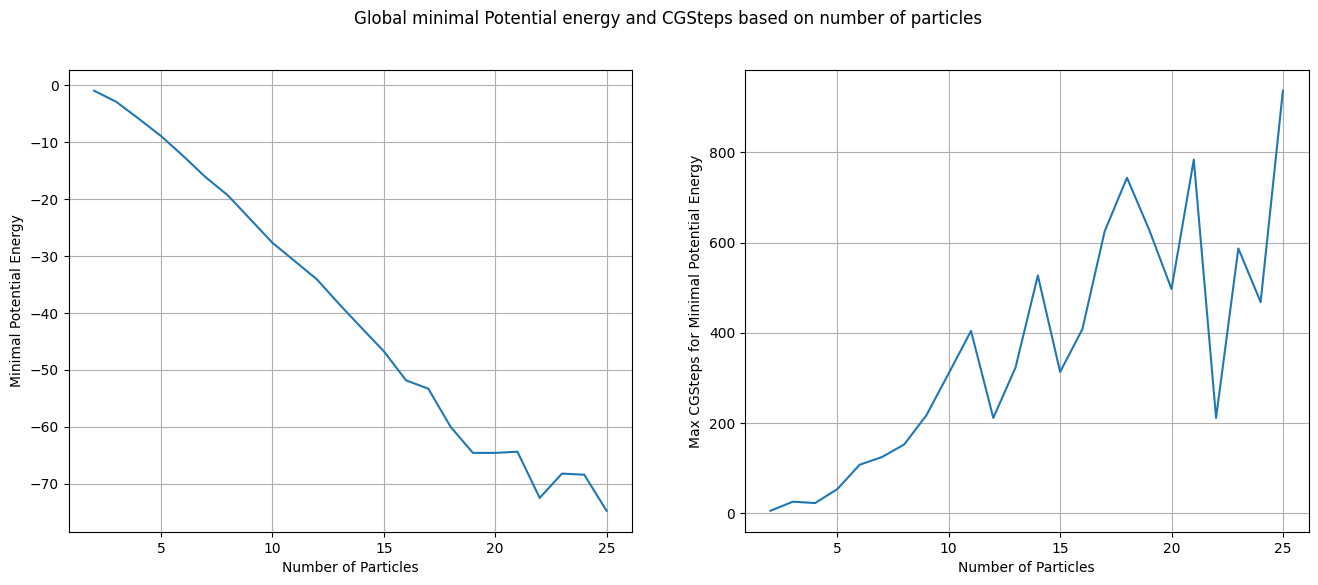

In [27]:
N_list = np.arange(2, 26)

plt.figure(figsize=(16,6))
# Plot global minimum potential energy based on number of particles
plt.subplot(1, 2, 1)
plt.plot(N_list, min_energy_list)
plt.xlabel('Number of Particles')
plt.ylabel('Minimal Potential Energy')
plt.grid(True)

# Plot num of CGSteps based on number of particles
plt.subplot(1, 2, 2)
plt.plot(N_list, CGSteps_list)
plt.xlabel('Number of Particles')
plt.ylabel('Max CGSteps for Minimal Potential Energy')
plt.grid(True)


plt.suptitle('Global minimal Potential energy and CGSteps based on number of particles')
plt.savefig('task2')

## Plotting and Visualizing Task 3

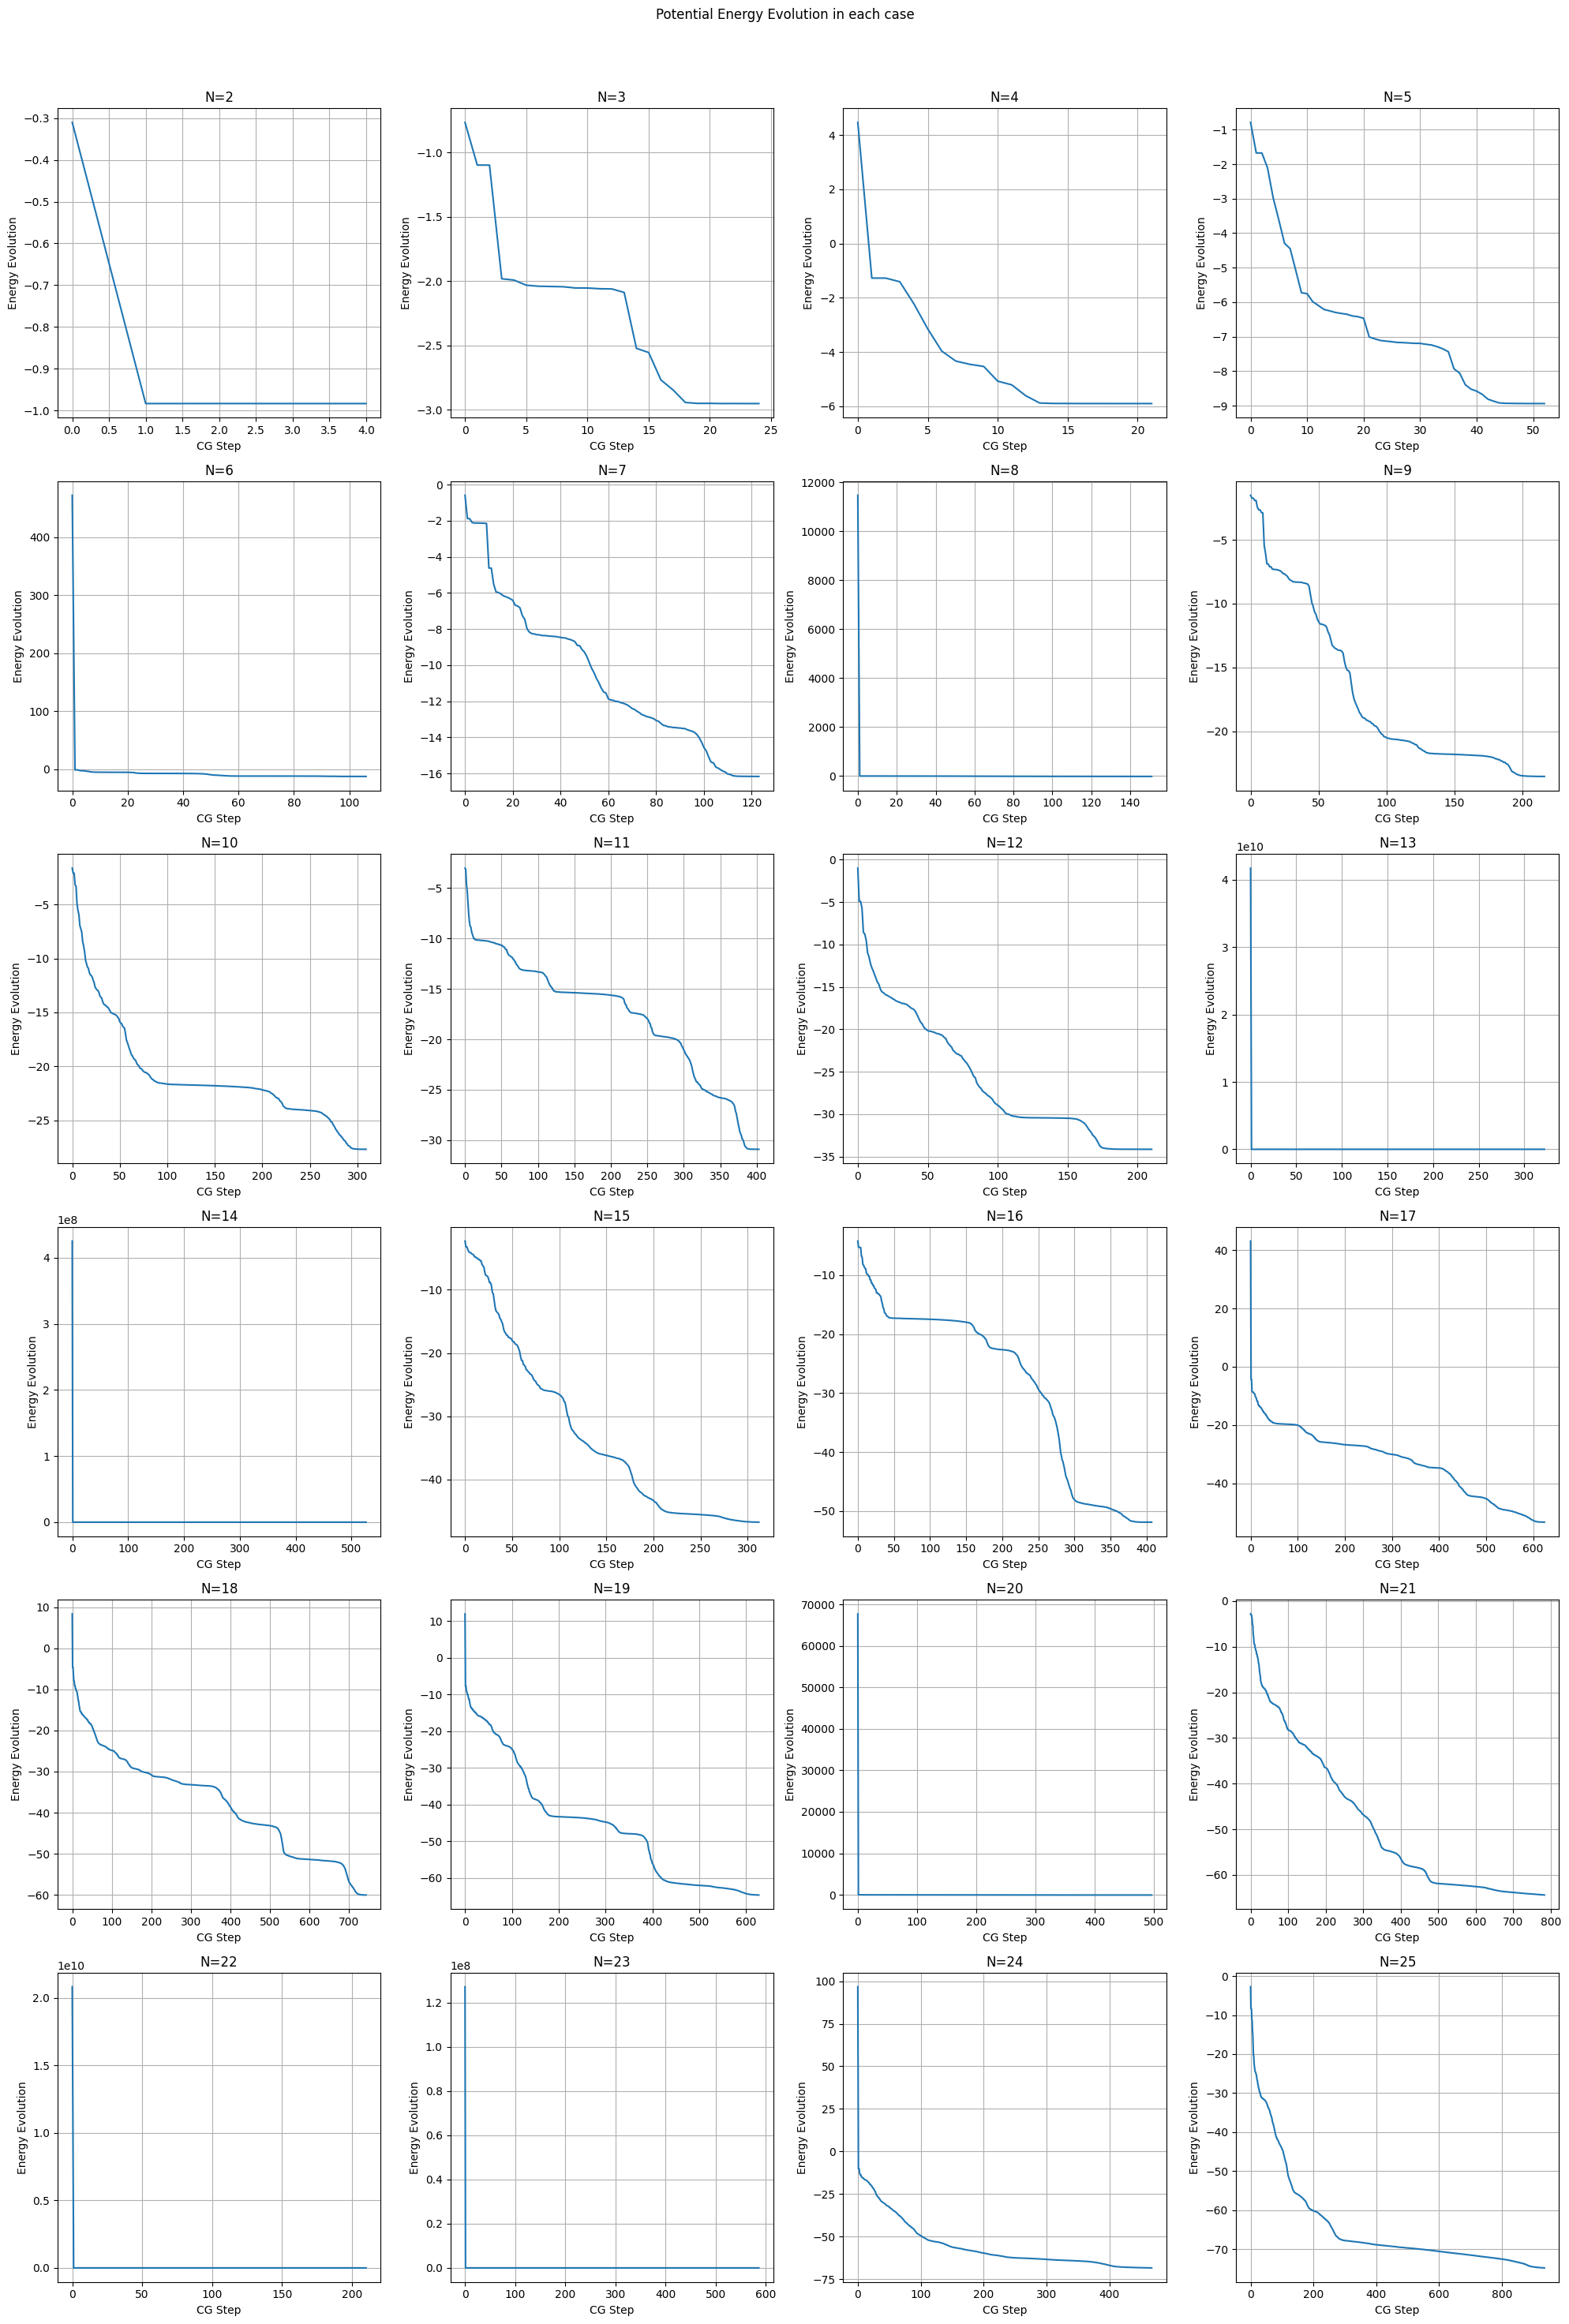

In [28]:
# Plot the evolution of Potential energy at each conjugate gradient step
plt.figure(figsize=(20, 30))
for N in N_list:
    index = N - 2
    plt.subplot(6, 4, index+1)
    plt.plot(np.arange(0, CGSteps_list[index]), energy_evolution_list[index])
    plt.xlabel('CG Step')
    plt.ylabel('Energy Evolution')
    plt.title(f'N={N}')
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.suptitle('Potential Energy Evolution in each case')
plt.savefig('task3')

In [31]:
# Visualize the trajectory of a cluster with 14 particles
traj = Trajectory('nano.traj', 'w')
i = 0
fac = 1.0
pos_list_C13 = trajectory_list[11]
while i < len(pos_list_C13):
    nano = Atoms('C13', pos_list_C13[i]*fac)
    i += 1
    traj.write(nano)

## Plotting Task 4

Fitted values: a = 14.528260508106344, b = -5.210223196276887, c = -1.9071650421722164


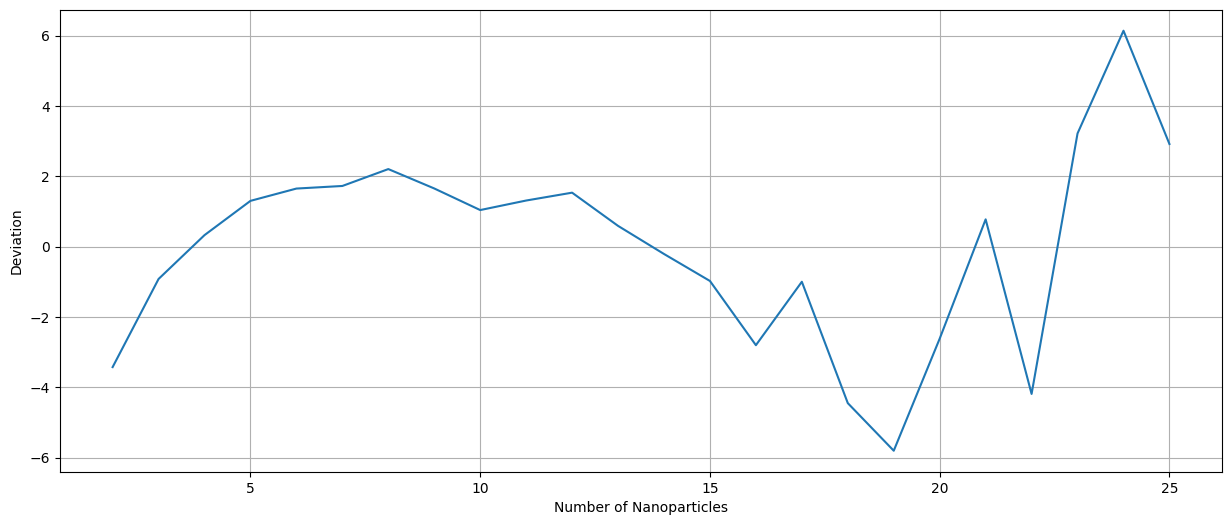

In [32]:
# Define the curve fitting function
def U_macro(N, a, b, c):
    return a + b * (N**(2/3)) + c * N

# Perform the least squares fitting
params, params_covariance = curve_fit(U_macro, N_list, min_energy_list)

# Extract fitted parameters
a, b, c = params
print(f"Fitted values: a = {a}, b = {b}, c = {c}")

deviation_list = min_energy_list - U_macro(N_list, *params)

plt.figure(figsize=(15, 6))
# Plot the data and the fitted curve
plt.plot(N_list, deviation_list)
plt.xlabel("Number of Nanoparticles")
plt.ylabel("Deviation")
plt.grid(True)
plt.savefig('task4')